2021년 10월 9일에 마지막으로 테스트되었습니다.  
이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 네이버 쇼핑 리뷰 분류하기의 튜토리얼입니다.

링크 : https://wikidocs.net/94600

## **10-07 (mecab) 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)**
---

In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 9.9 MB/s eta 0:00:00


---
### **1. Colab에 Mecab 설치**
---
여기서는 형태소 분석기 Mecab을 사용합니다. 저자의 경우 Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였습니다. 참고로 Colab에서 실습하는 경우가 아니라면 아래의 방법으로 Mecab이 설치되지 않습니다. 이 경우 해당 환경에 맞게 Mecab을 설치하시거나 다른 형태소 분석기를 사용하시기 바랍니다.

아래의 Mecab 설치는 Colab에서 실행한다고 가정하고 작성되었습니다.  
다른 환경이라면 별도의 Mecab 설치 과정을 거치거나 Okt 등과 같은 다른 형태소 분석기를 사용해주세요.

In [2]:
# Colab에 Mecab 설치
# !pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=d28328d56cdb2bbe06ed9e7f9672a709874c128445b10670614ea18663d978b0
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1191k      0  0:00:01  0:00:01 --:--:-- 2032k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9

In [3]:
import tensorflow as tf
tf.__version__  # 2024.08 2.17.0

'2.18.0'

---
### **2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리**
---
다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [4]:
from konlpy.tag import Mecab  # 2024.08

In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### **1) 데이터 로드하기**
위의 링크로부터 전체 데이터에 해당하는 ratings_total.txt를 다운로드합니다.

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x79831f7b24d0>)

해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가해주겠습니다.

In [7]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
# pd.read_csv('ratings_total.txt', delimiter='\t', names=['ratings', 'reviews'])

In [8]:
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


총 20만개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.

In [9]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


#### **2) 훈련 데이터와 테스트 데이터 분리하기**
현재 갖고 있는 데이터는 레이블을 별도로 갖고있지 않습니다. 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여합니다. 부여된 레이블은 새로 생성한 label이라는 열에 저장합니다.

In [10]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

In [11]:
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.

In [12]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. reviews열에서 중복을 제외한 경우 199,908개입니다. 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

In [13]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거

In [14]:
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


NULL 값 유무를 확인합니다.

In [15]:
print(total_data.isnull().values.any())

False


훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.

In [16]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

In [17]:
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


훈련용 리뷰의 경우 약 14만 9,900개. 테스트용 리뷰의 경우 약 4만 9,900개가 존재합니다.

#### **3) 레이블의 분포 확인**
훈련 데이터의 레이블의 분포를 확인해봅시다.

<Axes: xlabel='label'>

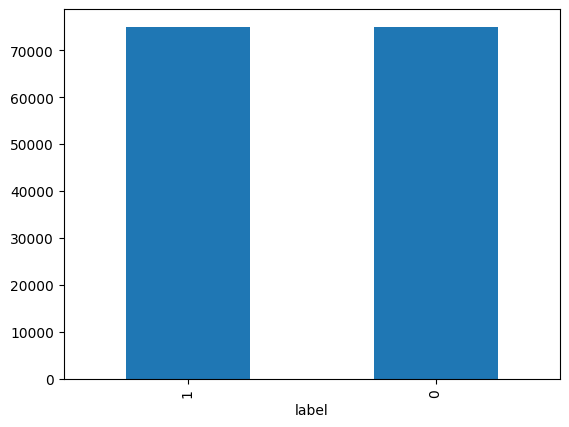

In [18]:
train_data['label'].value_counts().plot(kind = 'bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


두 레이블 모두 약 7만 5천개로 50:50 비율을 가지고 있습니다.

#### **4) 데이터 정제하기**
정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인합니다.

In [20]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,ratings,reviews,label
59666,2,사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...,0
12433,2,ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요,0
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...,0
158109,5,적당하고 만족합니다,1
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0


In [22]:
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


<ipython-input-22-85f3e9c81513>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


테스트 데이터에 대해서도 같은 과정을 거칩니다.

In [23]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-23-95386e1de338>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


#### **5) 토큰화**
형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행합니다. 다음은 임의의 문장에 대해서 테스트한 토큰화 결과입니다.

In [24]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


불용어를 지정하여 필요없는 토큰들은 제거하도록 합니다.

In [25]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

훈련 데이터와 테스트 데이터에 대해서 동일한 과정을 거칩니다.

In [26]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [27]:
train_data[train_data.label == 0]

,ratings,reviews,label,tokenized
59666,2,사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...,0,"[사이즈, 3, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라..."
12433,2,ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요,0,"[ㅂ, 불만족, ., ., 빗이, 아픔, ., ., 멍, 피부, 빗, 질, 못해, ..."
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...,0,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, ., 혹시나,..."
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 근, 많이, 서, 저, 패, 쓰, 요]"
55588,1,너무좋가겨 방금우리집데도둑기다,0,"[너무, 좋, 겨, 방금, 우리, 집, 데, 도둑, 기다]"
...,...,...,...,...
54890,2,즙 몇개가 터져서 상자밖까지 다젖어왔습니다. 나머지도 일일이 닦아내느라 짜증났네요....,0,"[즙, 몇, 개, 터져서, 상자, 밖, 까지, 젖, 어, 왔, 습니다, ., 나머지..."
110289,2,생각보다 퀄리티가 좀 떨어지네요 색상도 실물이랑 사진이랑 많이 다르구요... 선물용...,0,"[생각, 보다, 퀄리티, 좀, 떨어지, 네요, 색상, 실물, 이랑, 사진, 이랑, ..."
119904,2,그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...,0,"[그냥, 그래요, ㄷ, ㄷ, ㄷ, ㄷ, ㅂ, ㅂ, ㅂ, ㅂ, 그냥, 그래요, ㄷ, ..."
103714,2,비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...,0,"[비싸, 요, 진짜, 별거, 아니, 허접, 생겼, 는데, 이게, 만, 원, 라니, ..."


In [28]:
train_data[train_data.label == 0]['tokenized'].values

array([list(['사이즈', '3', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불만족', '.', '.', '빗이', '아픔', '.', '.', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '.', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '.', '.,', '많', '걸', '어쩌', '나요', ',', '..', '반품', '싶', '.', '.,']),
       ...,
       list(['그냥', '그래요', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ', '그냥', '그래요', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅁ', 'ㅁ', 'ㅁ', 'ㅁ', 'ㅋㅋ', 'ㅋㅋ', 'ㅌㅌㅌㅌㅍㅍㅍㅍ', 'ㄹ', 'ㄹ', 'ㄹ', 'ㄹ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㅎㅎ', 'ㅎㅎ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅈ', 'ㅈ', 'ㅈ', 'ㅈ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ']),
       list(['비싸', '요', '진짜', '별거', '아니', '허접', '생겼', '는데', '이게', '만', '원', '라니', '진짜', '가방', '구겨지', '것', '만', '아니', '면', '구매', '안', '했', '음', '!', '!']),
       list(['100', '장', '주문', '안', '됩니다', '500', '장', '가능', '해요'])],
   

#### **6) 단어와 길이 분포 확인하기**
긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

In [29]:
from collections import Counter

In [30]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [31]:
negative_words.shape, negative_words, positive_words.shape, positive_words

((1411111,),
 array(['사이즈', '3', '센치', ..., '장', '가능', '해요'], dtype='<U25'),
 (1109336,),
 array(['적당', '만족', '합니다', ..., '잘', '삿', '어요'], dtype='<U25'))

Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

In [32]:
negative_word_count = Counter(negative_words) # 파이썬의 Counter 모듈을 이용하면 단어의 모든 빈도를 쉽게 계산할 수 있습니다.
print(negative_word_count)

Counter({np.str_('.'): 77185, np.str_('네요'): 31942, np.str_('는데'): 20241, np.str_('안'): 19757, np.str_('어요'): 15232, np.str_('있'): 13203, np.str_('너무'): 12984, np.str_('했'): 11888, np.str_('좋'): 9804, np.str_('배송'): 9681, np.str_('..'): 9660, np.str_('같'): 9005, np.str_('어'): 8886, np.str_('구매'): 8872, np.str_('거'): 8868, np.str_('아요'): 8679, np.str_('없'): 8676, np.str_('습니다'): 8443, np.str_('그냥'): 8355, np.str_('되'): 8349, np.str_('잘'): 8011, np.str_('않'): 7982, np.str_('나'): 7524, np.str_('만'): 6892, np.str_('요'): 6774, np.str_('로'): 6698, np.str_('것'): 6400, np.str_('기'): 6376, np.str_('쓰'): 5883, np.str_(','): 5848, np.str_('아서'): 5828, np.str_('주'): 5713, np.str_('해서'): 5609, np.str_('서'): 5538, np.str_('으로'): 5444, np.str_('면'): 5443, np.str_('아'): 5384, np.str_('좀'): 5355, np.str_('었'): 5324, np.str_('보다'): 5324, np.str_('았'): 5322, np.str_('겠'): 5279, np.str_('먹'): 5252, np.str_('개'): 5230, np.str_('사용'): 5124, np.str_('제품'): 5086, np.str_('보'): 5063, np.str_('별로'): 4991, np.st

'네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장합니다.

In [33]:
negative_word_count.most_common(20)

[(np.str_('.'), 77185),
 (np.str_('네요'), 31942),
 (np.str_('는데'), 20241),
 (np.str_('안'), 19757),
 (np.str_('어요'), 15232),
 (np.str_('있'), 13203),
 (np.str_('너무'), 12984),
 (np.str_('했'), 11888),
 (np.str_('좋'), 9804),
 (np.str_('배송'), 9681),
 (np.str_('..'), 9660),
 (np.str_('같'), 9005),
 (np.str_('어'), 8886),
 (np.str_('구매'), 8872),
 (np.str_('거'), 8868),
 (np.str_('아요'), 8679),
 (np.str_('없'), 8676),
 (np.str_('습니다'), 8443),
 (np.str_('그냥'), 8355),
 (np.str_('되'), 8349)]

In [34]:
print(negative_word_count.most_common(20))

[(np.str_('.'), 77185), (np.str_('네요'), 31942), (np.str_('는데'), 20241), (np.str_('안'), 19757), (np.str_('어요'), 15232), (np.str_('있'), 13203), (np.str_('너무'), 12984), (np.str_('했'), 11888), (np.str_('좋'), 9804), (np.str_('배송'), 9681), (np.str_('..'), 9660), (np.str_('같'), 9005), (np.str_('어'), 8886), (np.str_('구매'), 8872), (np.str_('거'), 8868), (np.str_('아요'), 8679), (np.str_('없'), 8676), (np.str_('습니다'), 8443), (np.str_('그냥'), 8355), (np.str_('되'), 8349)]


긍정 리뷰에 대해서도 출력해봅시다.

In [35]:
positive_word_count = Counter(positive_words) # 파이썬의 Counter 모듈을 이용하면 단어의 모든 빈도를 쉽게 계산할 수 있습니다.
print(positive_word_count)

Counter({np.str_('좋'): 39455, np.str_('.'): 35659, np.str_('아요'): 21278, np.str_('네요'): 19912, np.str_('어요'): 19359, np.str_('잘'): 18608, np.str_('구매'): 16165, np.str_('습니다'): 13340, np.str_('있'): 12391, np.str_('배송'): 12274, np.str_('!'): 12007, np.str_('는데'): 11685, np.str_('했'): 10157, np.str_('~'): 9980, np.str_('합니다'): 9825, np.str_('먹'): 9643, np.str_('재'): 9268, np.str_('너무'): 8388, np.str_('같'): 7870, np.str_('만족'): 7250, np.str_('거'): 6489, np.str_('쓰'): 6291, np.str_('어'): 6281, np.str_('기'): 6193, np.str_('아'): 6142, np.str_('사용'): 5846, np.str_('요'): 5646, np.str_('해서'): 5428, np.str_('았'): 5412, np.str_('빠르'): 5233, np.str_('것'): 5202, np.str_('되'): 5171, np.str_('해요'): 4993, np.str_('지만'): 4956, np.str_('가격'): 4945, np.str_('으로'): 4941, np.str_('해'): 4849, np.str_('안'): 4797, np.str_('맛있'): 4735, np.str_('보다'): 4593, np.str_('로'): 4553, np.str_('겠'): 4253, np.str_('^^'): 4223, np.str_('었'): 4191, np.str_('어서'): 4190, np.str_('않'): 4143, np.str_('보'): 4136, np.str_('입니다'):

'좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다.

In [36]:
positive_word_count.most_common(20)

[(np.str_('좋'), 39455),
 (np.str_('.'), 35659),
 (np.str_('아요'), 21278),
 (np.str_('네요'), 19912),
 (np.str_('어요'), 19359),
 (np.str_('잘'), 18608),
 (np.str_('구매'), 16165),
 (np.str_('습니다'), 13340),
 (np.str_('있'), 12391),
 (np.str_('배송'), 12274),
 (np.str_('!'), 12007),
 (np.str_('는데'), 11685),
 (np.str_('했'), 10157),
 (np.str_('~'), 9980),
 (np.str_('합니다'), 9825),
 (np.str_('먹'), 9643),
 (np.str_('재'), 9268),
 (np.str_('너무'), 8388),
 (np.str_('같'), 7870),
 (np.str_('만족'), 7250)]

In [37]:
print(positive_word_count.most_common(20))

[(np.str_('좋'), 39455), (np.str_('.'), 35659), (np.str_('아요'), 21278), (np.str_('네요'), 19912), (np.str_('어요'), 19359), (np.str_('잘'), 18608), (np.str_('구매'), 16165), (np.str_('습니다'), 13340), (np.str_('있'), 12391), (np.str_('배송'), 12274), (np.str_('!'), 12007), (np.str_('는데'), 11685), (np.str_('했'), 10157), (np.str_('~'), 9980), (np.str_('합니다'), 9825), (np.str_('먹'), 9643), (np.str_('재'), 9268), (np.str_('너무'), 8388), (np.str_('같'), 7870), (np.str_('만족'), 7250)]


'좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다. 두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

긍정 리뷰의 평균 길이 : 14.788583312225882
부정 리뷰의 평균 길이 : 18.83540671133773


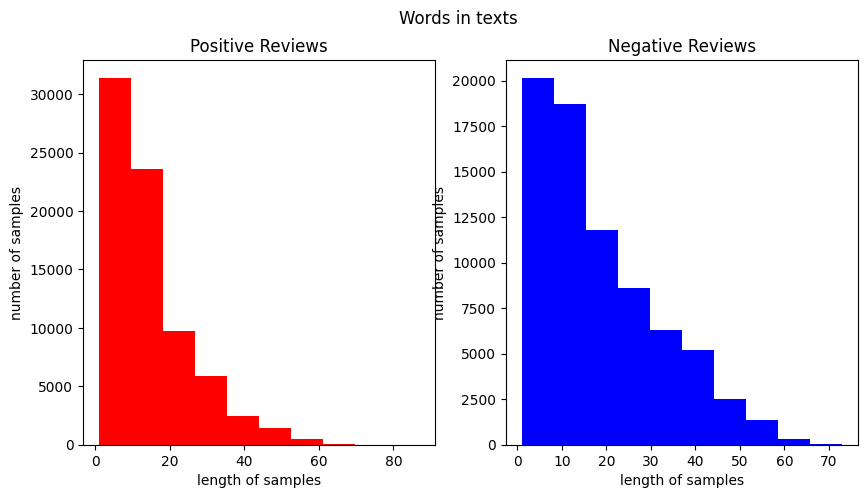

In [38]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [39]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [40]:
test_data

,ratings,reviews,label,tokenized
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0,"[너무, 낮, 솜, 적, 실망, 스럽, 습니다]"
125080,1,피부에 뾰루지가 많이 올라와요,0,"[피부, 뾰루지, 많이, 올라, 와요]"
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1,"[배송, 빠르, 네요, 가격, 대비, 좋, 것, 같, 아요, ~~~, 첨, 힘들, ..."
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1,"[재, 구매, 입니다, ., 핏, 좋, 착용감, 좋, 습니다, .]"
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0,"[파손, 제품, 온, 거, 출장, 같, 오늘, 받, 았, 는데, 현재, 상황, 장난..."
...,...,...,...,...
42438,2,연결해서 쓰려고 3단으로 2개 주문했는데..연결부위 맞추기가 넘 힘드네여 거기다 세...,0,"[연결, 해서, 쓰, 려고, 3, 단, 으로, 2, 개, 주문, 했, 는데, ., ..."
65471,2,허리는 너무크고 종아리는 꽉 끼어서 약간불편해 하네요 아들이 그래도 따뜻하다며 잘입...,0,"[허리, 너무, 크, 종아리, 꽉, 끼, 어서, 약간, 불편, 해, 네요, 아들, ..."
192593,5,샵에 가서 받았었는데 이거 구매하고 집에서 셀프로 하는데 넘나 좋으네요^^* 세트로...,1,"[샵, 서, 받, 았었, 는데, 이거, 구매, 집, 에서, 셀, 프로, 데, 넘, ..."
47486,4,가격도 착하고 다좋은데 조금얇은감이있네요 넓이도 조금커서 살짝헐렁거리지만 그래도 만...,1,"[가격, 착하, 좋, 은데, 조금, 얇, 감, 있, 네요, 넓이, 조금, 커서, 살..."


긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같습니다.

In [41]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [42]:
X_train[:3]

array([list(['사이즈', '3', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불만족', '.', '.', '빗이', '아픔', '.', '.', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '.', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '.', '.,', '많', '걸', '어쩌', '나요', ',', '..', '반품', '싶', '.', '.,'])],
      dtype=object)

In [43]:
y_train[:3]

array([0, 0, 0])

#### **7) 정수 인코딩**
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [45]:
print(tokenizer.word_index)

{'.': 1, '네요': 2, '좋': 3, '어요': 4, '는데': 5, '아요': 6, '잘': 7, '있': 8, '구매': 9, '안': 10, '했': 11, '배송': 12, '습니다': 13, '너무': 14, '같': 15, '거': 16, '어': 17, '먹': 18, '!': 19, '합니다': 20, '되': 21, '재': 22, '~': 23, '기': 24, '요': 25, '쓰': 26, '않': 27, '없': 28, '것': 29, '아': 30, '로': 31, '..': 32, '해서': 33, '사용': 34, '았': 35, '나': 36, '으로': 37, '만': 38, '보다': 39, '주': 40, '겠': 41, '었': 42, '지만': 43, ',': 44, '보': 45, '아서': 46, '그냥': 47, '해': 48, '제품': 49, '서': 50, '면': 51, '어서': 52, '가격': 53, '해요': 54, '좀': 55, '만족': 56, '생각': 57, '주문': 58, '입니다': 59, '라': 60, '더': 61, '받': 62, '니': 63, '개': 64, '할': 65, '맛': 66, '많이': 67, '사': 68, '시': 69, '때': 70, '사이즈': 71, '에서': 72, '샀': 73, '왔': 74, '번': 75, '빠르': 76, '음': 77, '작': 78, '?': 79, '맛있': 80, '포장': 81, '수': 82, '별로': 83, 'ㅠㅠ': 84, '두': 85, '입': 86, '맞': 87, '던': 88, '다른': 89, '^^': 90, '저렴': 91, '괜찮': 92, '세요': 93, 'ㅠ': 94, '넘': 95, '못': 96, '상품': 97, '정말': 98, '아니': 99, '하나': 100, '에요': 101, '냄새': 102, '일': 103, '데': 104, '부분': 105, '딱': 106

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [46]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42360
등장 빈도가 1번 이하인 희귀 단어의 수: 19706
단어 집합에서 희귀 단어의 비율: 46.520302171860244
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7818454424949226


단어가 약 40,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않습니다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 중요하지 않을 것으로 저자는 판단했습니다. 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다. 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한합니다.

In [47]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 22656


단어 집합의 크기는 21,787개입니다. 이를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환합니다. 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

In [48]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [49]:
print(tokenizer.word_index)

{'OOV': 1, '.': 2, '네요': 3, '좋': 4, '어요': 5, '는데': 6, '아요': 7, '잘': 8, '있': 9, '구매': 10, '안': 11, '했': 12, '배송': 13, '습니다': 14, '너무': 15, '같': 16, '거': 17, '어': 18, '먹': 19, '!': 20, '합니다': 21, '되': 22, '재': 23, '~': 24, '기': 25, '요': 26, '쓰': 27, '않': 28, '없': 29, '것': 30, '아': 31, '로': 32, '..': 33, '해서': 34, '사용': 35, '았': 36, '나': 37, '으로': 38, '만': 39, '보다': 40, '주': 41, '겠': 42, '었': 43, '지만': 44, ',': 45, '보': 46, '아서': 47, '그냥': 48, '해': 49, '제품': 50, '서': 51, '면': 52, '어서': 53, '가격': 54, '해요': 55, '좀': 56, '만족': 57, '생각': 58, '주문': 59, '입니다': 60, '라': 61, '더': 62, '받': 63, '니': 64, '개': 65, '할': 66, '맛': 67, '많이': 68, '사': 69, '시': 70, '때': 71, '사이즈': 72, '에서': 73, '샀': 74, '왔': 75, '번': 76, '빠르': 77, '음': 78, '작': 79, '?': 80, '맛있': 81, '포장': 82, '수': 83, '별로': 84, 'ㅠㅠ': 85, '두': 86, '입': 87, '맞': 88, '던': 89, '다른': 90, '^^': 91, '저렴': 92, '괜찮': 93, '세요': 94, 'ㅠ': 95, '넘': 96, '못': 97, '상품': 98, '정말': 99, '아니': 100, '하나': 101, '에요': 102, '냄새': 103, '일': 104, '데': 105, '부분': 1

X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.

In [50]:
print(X_train[:3])

[[72, 146, 2083, 313, 14804, 278, 79, 7, 254, 182, 148, 835, 3046, 659, 3, 85, 68, 219, 44, 1402, 168, 4, 7], [509, 2795, 2, 2, 8834, 2686, 2, 2, 2543, 353, 3017, 264, 2424, 41, 495, 3], [50, 27, 881, 104, 39, 2425, 171, 8, 11, 8343, 5, 2, 1375, 34, 149, 335, 46, 64, 171, 149, 8, 1980, 3, 2, 4629, 121, 177, 1443, 292, 45, 33, 130, 147, 2, 4629]]


In [51]:
print(X_test[:3])

[[15, 740, 803, 125, 198, 265, 14], [353, 4058, 68, 4159, 1705], [13, 77, 3, 54, 176, 4, 30, 16, 7, 398, 538, 304, 18, 101, 120, 611, 64, 8, 3]]


### **8) 패딩**
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 87
리뷰의 평균 길이 : 16.810712927946856


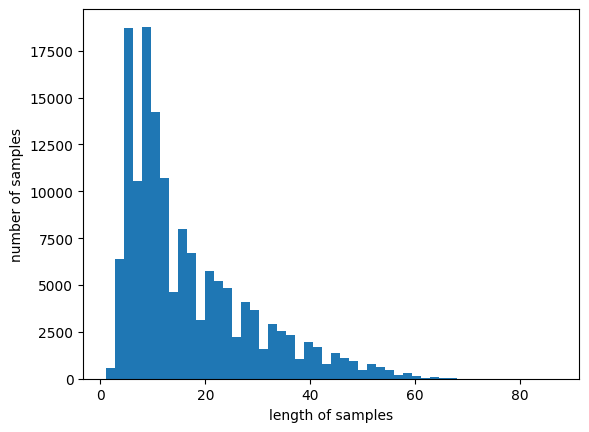

In [52]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이는 85, 평균 길이는 약 15입니다. 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [53]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

In [54]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99866605305107


훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.

In [55]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [56]:
X_train.shape

(149931, 80)

In [57]:
X_train[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    72,   146,  2083,   313, 14804,   278,
           79,     7,   254,   182,   148,   835,  3046,   659,     3,
           85,    68,   219,    44,  1402,   168,     4,     7],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            

---
### **3. GRU로 네이버 쇼핑 리뷰 감성 분류하기**
---
하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다. 모델은 다 대 일 구조의 LSTM를 사용합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행합니다.

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [58]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [61]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8552 - loss: 0.3468
Epoch 1: val_acc improved from -inf to 0.91223, saving model to best_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - acc: 0.8552 - loss: 0.3468 - val_acc: 0.9122 - val_loss: 0.2395
Epoch 2/15
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9212 - loss: 0.2202
Epoch 2: val_acc improved from 0.91223 to 0.91630, saving model to best_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9212 - loss: 0.2202 - val_acc: 0.9163 - val_loss: 0.2299
Epoch 3/15
1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9295 - loss: 0.2001
Epoch 3: val_acc improved from 0.91630 to 0.92433, saving model to best_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9295 - loss: 0.2001 - val_acc: 0.9243 - val_loss: 0.2086
Epoch 4/15
1995/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9359 - loss: 0.1838
Epoch 4: val_acc did not improve from 0.92433
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - acc: 0.9359 - loss: 0.1838 - val_acc: 0.9232 - val_loss: 0.2124
Epoch 5/15
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9397 - loss: 0.1755
Epoch 5: val_acc improved from 0.92433 to 0.92467, saving model to best_model.h5


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - acc: 0.9397 - loss: 0.1755 - val_acc: 0.9247 - val_loss: 0.2083
Epoch 6/15
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9463 - loss: 0.1614
Epoch 6: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - acc: 0.9463 - loss: 0.1614 - val_acc: 0.9240 - val_loss: 0.2135
Epoch 7/15
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9491 - loss: 0.1524
Epoch 7: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - acc: 0.9491 - loss: 0.1524 - val_acc: 0.9225 - val_loss: 0.2149
Epoch 8/15
1995/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9529 - loss: 0.1434
Epoch 8: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - acc: 0.9529 - loss: 0.1434 - val_acc: 0.9193 - val_loss: 0.2296
Epoch 9/15
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9567 - loss: 0.1320
Epoch 9: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step 

In [62]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9591 - loss: 0.1254
Epoch 1: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9590 - loss: 0.1254 - val_acc: 0.9176 - val_loss: 0.2423
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9610 - loss: 0.1181
Epoch 2: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - acc: 0.9610 - loss: 0.1181 - val_acc: 0.9147 - val_loss: 0.2535
Epoch 3/15
1996/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9654 - loss: 0.1069
Epoch 3: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - acc: 0.9654 - loss: 0.1069 - val_acc: 0.9140 - val_loss: 0.2657
Epoch 4/15
1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9669 - loss: 0.1018
Epoch 4: val_acc did not improve from 0.92467
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - acc: 0.9669 - loss: 0.1018 - val_acc: 0.9132 - val_loss: 0.2666
Epoch 5/15
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 

저자의 경우 에포크 10에서 조기 종료가 발생했습니다.

In [63]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9261 - loss: 0.2081

 테스트 정확도: 0.9239


<Axes: >

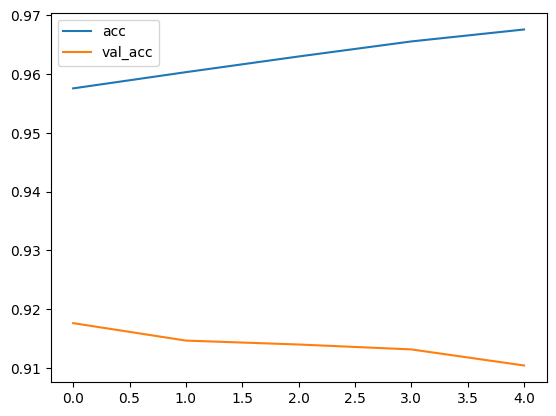

In [64]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history[['acc', 'val_acc']].plot()

<Axes: >

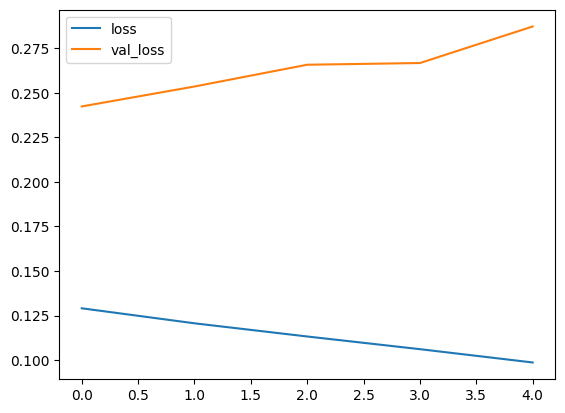

In [65]:
df_history[['loss', 'val_loss']].plot()

---
### **4. 리뷰 예측해보기**
---
임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다. 전처리의 순서는 정규 표현식을 통한 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩 순입니다.

In [66]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [67]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
96.24% 확률로 긍정 리뷰입니다.


<ipython-input-66-5a6a6ba7d525>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [68]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
99.39% 확률로 부정 리뷰입니다.


<ipython-input-66-5a6a6ba7d525>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [69]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
96.64% 확률로 긍정 리뷰입니다.


<ipython-input-66-5a6a6ba7d525>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [70]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
91.64% 확률로 부정 리뷰입니다.


<ipython-input-66-5a6a6ba7d525>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
